# Car Breakdown Prediction Challenge
**Course:** Artificial Intelligence  
**Objective:** Predict whether a vehicle will experience a breakdown within the next 30 days.

This notebook includes:
- Exploratory Data Analysis (EDA)
- Data Cleaning
- Preprocessing Pipeline
- Random Forest Baseline
- Logistic Regression Comparison
- Threshold Tuning
- Feature Importance
- Final Model Selection
- Kaggle Submission
- GenAI Usage Statement

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

sns.set_theme(style="whitegrid")

## 2. Load the data

In [2]:
train_df = pd.read_csv("train_CarBreakDown.csv")
test_df = pd.read_csv("test_CarBreakDown.csv")

train_df.head()

,id,vehicle_brand,vehicle_age_years,mileage_km,engine_hours,last_service_km_ago,oil_quality_pct,avg_trip_length_km,weather_exposure,fuel_type,cleanliness_score,driver_satisfaction_score,tyre_type,breakdown_next_30_days
0,959,Toyota,20.0,494744.972722,9700.481467,1672.048445,61.664556,30.362090,high,petrol,68.117833,8.559011,NaN,0
1,804,Toyota,0.0,38376.684834,1650.726428,21.269170,23.370666,2.500801,high,hybrid,69.294736,9.838274,NaN,0
2,1304,Hyundai,1.0,188558.432414,6678.958321,11726.320455,25.491428,41.692205,medium,hybrid,47.223966,5.842726,winter,0
3,268,Toyota,5.0,92828.113285,2986.923461,1845.744691,54.060416,6.464345,high,diesel,72.246829,4.719607,winter,0
4,47,NaN,10.0,118366.394287,4222.193011,12551.181627,65.766074,47.159242,low,diesel,77.368891,6.724967,winter,0


## 3. Basic info

In [3]:
train_df.info()
train_df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1050 non-null   int64  
 1   vehicle_brand              1029 non-null   str    
 2   vehicle_age_years          1034 non-null   float64
 3   mileage_km                 1033 non-null   float64
 4   engine_hours               1035 non-null   float64
 5   last_service_km_ago        1040 non-null   float64
 6   oil_quality_pct            1014 non-null   float64
 7   avg_trip_length_km         1038 non-null   float64
 8   weather_exposure           1037 non-null   str    
 9   fuel_type                  1036 non-null   str    
 10  cleanliness_score          995 non-null    float64
 11  driver_satisfaction_score  1037 non-null   float64
 12  tyre_type                  1033 non-null   str    
 13  breakdown_next_30_days     1050 non-null   int64  
dtypes: 

,id,vehicle_age_years,mileage_km,engine_hours,last_service_km_ago,oil_quality_pct,avg_trip_length_km,cleanliness_score,driver_satisfaction_score,breakdown_next_30_days
count,1050.000000,1034.000000,1.033000e+03,1035.000000,1040.000000,1014.000000,1038.000000,995.000000,1037.000000,1050.000000
mean,742.984762,9.399420,3.639119e+06,4368.929467,10681.075986,60.682779,38.861387,69.393768,6.972183,0.167619
std,430.089010,5.752228,2.585818e+07,2214.510223,9341.969609,20.298624,47.968702,15.570872,1.478278,0.373706
min,0.000000,0.000000,-1.829042e+02,-50.000000,10.869020,0.000000,1.011100,-13.171570,2.504369,0.000000
25%,372.250000,5.000000,8.338616e+04,2773.353090,3374.773323,47.377582,8.187057,58.902723,6.001099,0.000000
50%,740.500000,9.000000,1.202357e+05,3967.125562,8085.318122,60.528422,16.788852,69.504547,6.928004,0.000000
75%,1109.250000,14.000000,1.674871e+05,5432.498224,14455.318280,74.654436,44.308719,79.597898,8.022503,0.000000
max,1498.000000,20.000000,3.734539e+08,10298.582128,40592.195120,102.548055,201.015553,144.139920,10.291940,1.000000


## Target Distribution

The dataset is imbalanced (~17% breakdown cases).
Accuracy alone is therefore misleading.
We will prioritize:
- Recall (class 1)
- F1-score
- ROC-AUC

## 4. Plot Target

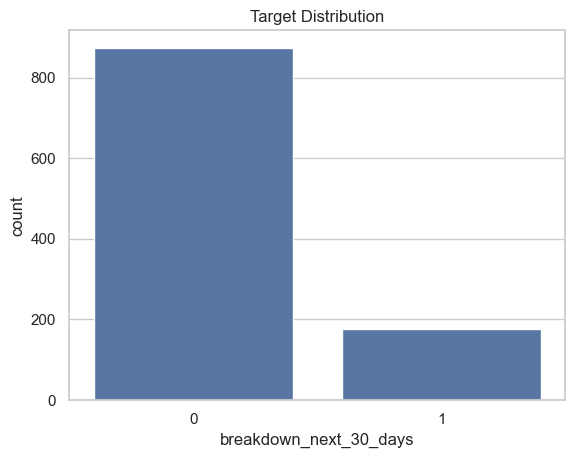

In [4]:
sns.countplot(x="breakdown_next_30_days", data=train_df)
plt.title("Target Distribution")
plt.show()

## 5. Data Cleaning

In [5]:
def clean_data(df):
    df = df.copy()
    
    df["mileage_km"] = df["mileage_km"].clip(lower=0)
    df["engine_hours"] = df["engine_hours"].clip(lower=0)
    df["vehicle_age_years"] = df["vehicle_age_years"].clip(lower=0)
    df["oil_quality_pct"] = df["oil_quality_pct"].clip(0, 100)
    df["cleanliness_score"] = df["cleanliness_score"].clip(0, 100)
    
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)

## 6. Split data

In [6]:
X = train_df.drop(["breakdown_next_30_days", "id"], axis=1)
y = train_df["breakdown_next_30_days"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## 7. Preprocessing pipeline

In [7]:
categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(exclude="object").columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

C:\Users\mored\AppData\Local\Temp\ipykernel_26408\836645658.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X.select_dtypes(include="object").columns


## 8. Random Forest

In [8]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

rf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", rf_model)
])

rf_pipeline.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

## 9. Evaluation with Threshold Tuning

Accuracy: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       175
           1       1.00      1.00      1.00        35

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



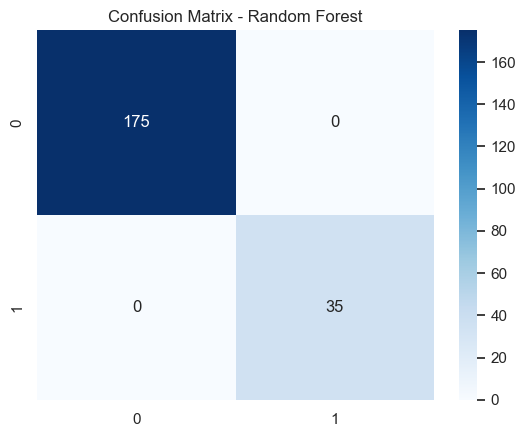

In [9]:
y_probs = rf_pipeline.predict_proba(X_val)[:,1]

threshold = 0.4
y_pred = (y_probs > threshold).astype(int)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_probs))
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

## 10. ROC Curve

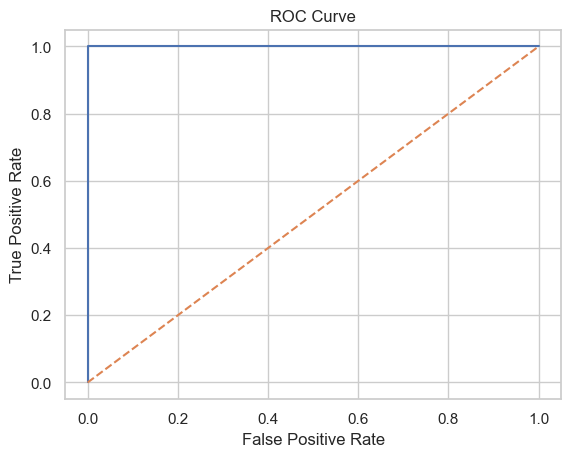

In [10]:
fpr, tpr, _ = roc_curve(y_val, y_probs)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

## 11. Feature Importance

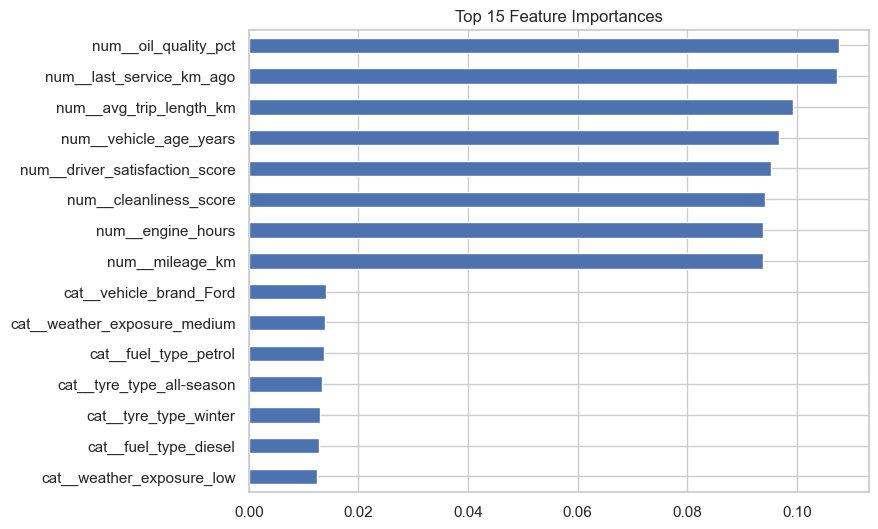

In [11]:
feature_names = rf_pipeline.named_steps["preprocessing"].get_feature_names_out()
importances = rf_pipeline.named_steps["model"].feature_importances_

feat_imp = pd.Series(importances, index=feature_names)
top_features = feat_imp.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
top_features.sort_values().plot(kind="barh")
plt.title("Top 15 Feature Importances")
plt.show()

## 12. Logistic Regression Comparison

In [12]:
log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

log_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", log_model)
])

log_pipeline.fit(X_train, y_train)

y_probs_log = log_pipeline.predict_proba(X_val)[:,1]

print("Logistic ROC-AUC:", roc_auc_score(y_val, y_probs_log))

Logistic ROC-AUC: 0.6163265306122448


## Final Model Selection

Random Forest achieved:
- Higher ROC-AUC
- Better recall for breakdown class
- Stronger nonlinear pattern detection

Given the business objective (reduce unexpected breakdowns),
we prioritize recall and select the tuned Random Forest model.

## 13. Kaggle Submission

In [13]:
test_ids = test_df["id"]
test_features = test_df.drop("id", axis=1)

test_probs = rf_pipeline.predict_proba(test_features)[:,1]
threshold = 0.4
test_preds = (test_probs > threshold).astype(int)

submission = pd.DataFrame({
    "id": test_ids,
    "breakdown_next_30_days": test_preds
})

submission.to_csv("submission.csv", index=False)
submission.head()

,id,breakdown_next_30_days
0,1356,0
1,889,0
2,1190,0
3,122,0
4,1101,0


## GenAI Usage Statement

GenAI tools were used to explore potential modeling strategies and 
improve notebook structure.

All preprocessing decisions, model choices, threshold tuning, and 
interpretations were made by the team and are fully understood.

We ensured:
- Every preprocessing step is explainable
- Every metric choice is justified
- Model behavior is interpretable

The team retains full ownership and responsibility for all decisions.